# Project Introduction 

Welcome! This is the notebook for our CS445 Final Project. For this project, we decided to explore Kolmogorov-Arnold Networks, also called KANs. Kolmogorov-Arnold Networks are a network that is a promising alternative to a Multi-Layer Perceptron as KANs have learnable activation functions on the edges. The KAN theorem proves that multivariate functions can be reduced to sums and compositions of univariate ones. (KANs) which use univariate function learning at each node, rather than dot products, offering a new universal function approximator architecture. What makes KANs so interesting is that they do not have learnable weights at all because every single parameter is replaced by a spline. A spline is a univariate function that is applied to each input dimension. They are typically piecewise polynomial functions where knots and coefficients are learned. These functions are continuously differentiable, which means that they can achieve smoother loss landscapes than that of the MLP. KANs are especially useful for learning direct mappings of input to output. Applications of KANS consists of modeling physical systems that require partial differential equations, transparent modeling, strong generalization on tabular data in finance or health care. KANs excel against the Multi-Layer Perceptron especially when the data is scarce and due to their spline nature they are able to achieve similar results with less parameters. 

The Multi Layer Perceptron is the standard for when it comes to machine learning. It is a feedforward neural network that consists of the input layer, fully connected or hidden layers, activation functions such as RelU, SiLU, edges and learned weights, and the output layer. Each layer in the MLP applies a linear transformation and then the activation function. The weights and the bias are learned on the edges of the network and activation functions shaping the flow of data.  MLP is widely used as the standard for the final layers in image classification, feedforward layers in natural language processing, regression and classification of tabular data, and time series data. Because of its wide use, it overshadows the KAN, and the MLP is not without its issues. MLP can be very inefficient in its parameter usage for complex functions because for complex functions more neurons, layers, and parameters are needed. 

This brings forth an interesting scenario where due to the MLP’s wide usage, KANs have been under researched and overshadowed as an alternative to the common CNN and MLP as heads combination. Through our work we intend to analyze whether the KAN is a viable alternative against the Multi-Layer Perceptron in image classification tasks. To do this, we are using the tiny imagnet dataset, which contains 100,000 images, 200 classes, and 500 images per class. Through this dataset we are able to investigate the strengths of the KAN vs. MLP for image classification algorithms. 

See the dataset here on huggingface : https://huggingface.co/datasets/zh-plus/tiny-imagenet



# Methodology : 

In this section, we will compare the performance of a KAN vs. MLP on a shared CNN backbone using Tiny ImageNet dataset. 


Exploratory Questions :

While conducting our research/project, we had many questions that we wanted to answer in regards to the KAN. 

What are the Benefits of Using a Kolmogrov-Arnold layers vs CNN + MLP layers?
How does the choice of the baseline activation function for the b-splines impact model performance and training dynamics?
How do KANs perform in transfer learning scenarios?
Is it possible to achieve the same performance with a fraction of the parameters?




In [6]:
import sys
print(sys.executable)


/opt/homebrew/opt/python@3.11/bin/python3.11


### Imports

In [10]:
%pip install bayesian-optimization torch torchvision pandas seaborn matplotlib scikit-learn datasets ptflops


  Using cached bayesian_optimization-2.0.3-py3-none-any.whl.metadata (9.0 kB)
  Using cached torchvision-0.22.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached pillow-11.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached contourpy-1.3.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached bayesi

In [11]:
from __future__ import annotations
import random
from pathlib import Path
from typing import Tuple, Dict, List
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
from bayes_opt import BayesianOptimization
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import (
    Compose, Resize, RandomHorizontalFlip,
    ToImage, ToDtype, Normalize
)
from ptflops import get_model_complexity_info
from torchvision.utils import make_grid

In [14]:
# -----------------------  constants  ---------------------------------
SEED               = 42
N_EPOCHS           = 25
BATCH_SIZE         = 128
IMAGE_SIZE         = (64, 64)            # Tiny‑ImageNet native size
LEARNING_RATE      = 0.002335
WEIGHT_DECAY       = 1e-5
MEAN        = [0.485, 0.456, 0.406]   # ImageNet stats
STD         = [0.229, 0.224, 0.225]
RUN_DIR            = Path("runs/tinyimagenet_cnn_vs_kan").resolve()
RUN_DIR.mkdir(parents=True, exist_ok=True)

random.seed(SEED)
torch.manual_seed(SEED)

device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps")  if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print(f"➡️  Using device: {device}")


➡️  Using device: mps


### Data Prep

In [15]:
def get_dataloaders(
    batch_size: int = BATCH_SIZE,
    image_size: Tuple[int, int] = IMAGE_SIZE
):
    # ── 1. load and split ──────────────────────────────────────────────
    ds       = load_dataset("zh-plus/tiny-imagenet", split=None)      # train / valid
    split    = ds["train"].train_test_split(
        test_size=0.15, seed=SEED, stratify_by_column="label"
    )
    train_ds = split["train"]           # 90 % → training
    val_ds   = split["test"]            # 10 % → internal val
    test_ds  = ds["valid"]              # official Tiny‑IN val → test set

    # ── 2. define transforms ───────────────────────────────────────────
    train_tfms = Compose([
        ToImage(),                              # PIL → tensor
        RandomHorizontalFlip(p=0.5),
        ToDtype(torch.float32, scale=True),     # convert + /255
        Normalize(MEAN, STD),
    ])
    eval_tfms = Compose([
        ToImage(),
        ToDtype(torch.float32, scale=True),
        Normalize(MEAN, STD),
    ])

    # wrap for HF set_transform (expects dict in, dict out)
    train_ds.set_transform(lambda ex: {
        "image": train_tfms(ex["image"]),
        "label": ex["label"],
    })
    for split_ds in (val_ds, test_ds):
        split_ds.set_transform(lambda ex: {
            "image": eval_tfms(ex["image"]),
            "label": ex["label"],
        })

    # ── 3. torch DataLoaders ───────────────────────────────────────────
    mk_loader = partial(
        DataLoader,
        batch_size=batch_size,
        pin_memory=True,
    )
    train_loader = mk_loader(train_ds, shuffle=True,  drop_last=True)
    val_loader   = mk_loader(val_ds,   shuffle=False, drop_last=False)
    test_loader  = mk_loader(test_ds,  shuffle=True, drop_last=False)

    return train_loader, val_loader, test_loader

### Baseline CNN Architecture

The baseline is a standard convolutional neural network that is designed for image classification with 200 classes. It uses a four stage block to extract features and then a multi-layer perceptron head for classification. The convolutional features in conv1 are 3 input channels, 64 filters with a 3x3 conv and ReLU as the activation function. The second layer has 64 input channels with 128 filters, a 5x5 conv, to ReLU to MaxPool for downsampling. The third layer has 128 inputs to 256 filters, 3x3 conv, to ReLU to MaxPool. Layer 4 has 256 inputs and 512 filters, 3x3 conv to ReLU. After this layer global average pooling compresses the spatial dimensions to 1x1 leaving 512 channels of feature depth. The MLP head consists of a call from Linear(512, 384), to Linear(384, 256), to Linear(256, 200) which is the final amount of classes in the output layer. The advantages of this network is that it gets progressively deeper, global average pooling reduces overfitting and model size by flattening dimensions, and ReLU ensures stable and fast convergence. Dropout layers also add regularization that works to prevent overfitting. The downside of the model is that there is no dynamic receptive field, the model is parameter heavy due to the MLP, and that early features can be lost when each layer’s output fully overwrites the previous one without skip connections to preserve low-level information.


Layer breakdown: Traditional CNN with MLP layers
Convolutional layers (kernel sizes, strides, padding)
Pooling layers
4 Fully connected layers
Activation functions and normalizations
Total parameter count: 8,673,320


In [16]:
class BaselineCNN(nn.Module):
    def __init__(self, n_classes: int = 200, dropout_p: float = 0.1):
        super().__init__()

        # ── Convolutional feature extractor ──────────────────────────────
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(2)  # 64→32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64→32
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16→8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(2)  # 8→4
        )
        # Global average pooling flattens to (B,512)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # ── Classifier head ──────────────────────────────────────────────
        self.ffn = nn.Sequential(
            nn.Linear(512, 384),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(256, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x).view(x.size(0), -1)  # flatten
        x = self.ffn(x)
        return x

### KAN-based CNN Architecture

Our KAN setup uses the same backbone as the BaseLineCNN, with the key difference in architectures being the head. At the head, each layer contains learnable B-spline activation functions. The splines can be adjusted with the number of control points, the spline degree, and the input domain the splines are defined over. While the network trains, it is able to learn specific shapes and map it to the data, allowing the model to understand connections. Each node in the network has a more expensive function, but because of this, you can use fewer layers or units to get similar or better performance, compared to MLPs. The KAN structure is also different because the transformation happens at the node level, rather than weights and edges like a normal CNN. One bonus is that spline shapes can be visualized, which can offer unique insight into what each node is learning. Some of the pitfalls of the KAN model includes the tuning required to get the model accurate, the increased node complexity means that the KAN can have trouble scaling on large datasets or models, and the additional computational overhead can make training and inference slower compared to the MLP.  

Layer breakdown: Experimental CNN with KA Layers

Convolutional layers (same as baseline)
KA layers with B-splines replacing MLPs
Implementation details of the KA layers
Total parameter count 1,775,154



In [5]:
from classes.BSplineActivation import BSplineActivation

class KANCNN(nn.Module):

    def __init__(self,
                 n_classes: int = 200,
                 input_shape=(3, 64, 64),
                 ch1: int = 64, ch2: int = 128, ch3: int = 256, ch4: int = 512,
                 kan_1: int = 384, kan_2: int = 384, kan_3: int = 200,
                 spline_cp: int = 7, spline_deg: int = 3,
                 range_min: float = -3.0, range_max: float = 90.0,
                 dropout_p: float = 0.1):
        super().__init__()
        C_in, *_ = input_shape

        # ── 1. Convolutional feature extractor (same as BaselineCNN) ──────
        self.conv1 = nn.Sequential(
            nn.Conv2d(C_in, ch1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 64→32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(ch1, ch2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32→16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(ch2, ch3, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16→8
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(ch3, ch4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(ch4),
            nn.ReLU(inplace=True),  # 8→4
        )
        self.gap = nn.AdaptiveAvgPool2d(1)  # 4×4 → 1×1

        # ── 2. KAN head ──────────────────────────────────────────────────
        flat_dim = ch4  # == 512 by default
        self.dropout = nn.Dropout(dropout_p)

        self.kan1 = nn.Linear(flat_dim, kan_1)
        self.kan1_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        #self.kan2 = nn.Linear(kan_1, kan_2)
        #self.kan2_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        self.kan3 = nn.Linear(kan_1, kan_3)
        self.kan3_act = BSplineActivation(spline_cp, spline_deg, range_min, range_max)

        # Optional: final classifier to logits (comment out if not needed)
        self.classifier = nn.Linear(kan_3, n_classes)

    # ── 3. Forward pass ────────────────────────────────────────────────
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x).view(x.size(0), -1)

        x = self.kan1_act(self.kan1(x))
        #x = self.kan2_act(self.kan2(x))
        x = self.kan3_act(self.kan3(x))

        logits = self.classifier(x)
        return logits


### Training Loop

In [6]:
# ---------------  training / eval helpers  ---------------------------
import json
import time


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    return (logits.argmax(dim=1) == targets).float().mean()

def train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer, epoch: int) -> Dict[str, float]:
    model.train()
    loss_sum = acc_sum = 0.0
    for batch in tqdm(loader, desc=f"Train {epoch:02d}", leave=False):
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        acc = accuracy_from_logits(logits, y)
        loss_sum += loss.item() * x.size(0)
        acc_sum  += acc.item()  * x.size(0)

    n = len(loader.dataset)
    return {"loss": loss_sum / n, "acc": acc_sum / n}

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Dict[str, float]:
    model.eval()
    loss_sum = acc_sum = 0.0
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        acc = accuracy_from_logits(logits, y)
        loss_sum += loss.item() * x.size(0)
        acc_sum  += acc.item() * x.size(0)
    n = len(loader.dataset)
    return {"loss": loss_sum / n, "acc": acc_sum / n}

def run_training(model:nn.Module, name:str,
                 train_loader:DataLoader, val_loader:DataLoader) -> Dict[str, List[float]]:
    """Full training loop for one model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, N_EPOCHS+1):
        tic = time.time()
        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        val_metrics   = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])

        print(f"Epoch {epoch:2d}/{N_EPOCHS} • "
              f"Training Accuracy {train_metrics['acc']*100:5.2f}% | "
              f"Validation Accuracy {val_metrics['acc']*100:5.2f}% | "
              f"Epoch time {time.time()-tic:4.1f}s")

    torch.save(model.state_dict(), RUN_DIR/f"{name}.pt")
    with open(RUN_DIR/f"{name}_history.json", "w") as f:
        json.dump(history, f)
    return history

In [7]:
train_loader, val_loader, test_loader = get_dataloaders()

baseline = BaselineCNN()
kan      = KANCNN()


In [ ]:
print("Training MLP CNN …")
baseline_model = run_training(baseline, "baseline", train_loader, val_loader)

Training MLP CNN …


Epoch  1/25 • Training Accuracy  5.09% | Validation Accuracy  8.63% | Epoch time 163.5s


Epoch  2/25 • Training Accuracy 11.15% | Validation Accuracy 13.79% | Epoch time 162.1s


Epoch  3/25 • Training Accuracy 14.85% | Validation Accuracy 14.40% | Epoch time 163.3s


Train 04:  66%|██████▋   | 440/664 [01:43<00:53,  4.15it/s]

In [95]:
print("\n🌀 Training KAN‑CNN …")
hist_kan  = run_training(kan,      "KAN",      train_loader, val_loader)


🌀 Training KAN‑CNN …


Epoch  1/10 • Training Accuracy  3.11% | Validation Accuracy  5.93% | Epoch time 799.9s


Epoch  2/10 • Training Accuracy  8.62% | Validation Accuracy 11.67% | Epoch time 48.3s


Epoch  3/10 • Training Accuracy 13.22% | Validation Accuracy 11.88% | Epoch time 578.9s


Epoch  4/10 • Training Accuracy 16.63% | Validation Accuracy 17.26% | Epoch time 48.5s


Epoch  5/10 • Training Accuracy 19.79% | Validation Accuracy 19.77% | Epoch time 48.4s


Epoch  6/10 • Training Accuracy 22.82% | Validation Accuracy 22.61% | Epoch time 48.0s


Epoch  7/10 • Training Accuracy 24.90% | Validation Accuracy 24.98% | Epoch time 47.7s


Epoch  8/10 • Training Accuracy 27.14% | Validation Accuracy 25.04% | Epoch time 47.8s


Epoch  9/10 • Training Accuracy 29.23% | Validation Accuracy 26.92% | Epoch time 47.8s


Epoch 10/10 • Training Accuracy 31.48% | Validation Accuracy 29.11% | Epoch time 47.8s


In [96]:
criterion = nn.CrossEntropyLoss()
test_base = evaluate(baseline, test_loader, criterion)
test_kan  = evaluate(kan,      test_loader, criterion)


print(f"\n✅ Test accuracy: "
        f"Baseline {test_base['acc']*100:5.2f}% | "
        f"KAN {test_kan['acc']*100:5.2f}%")



✅ Test accuracy: Baseline 29.80% | KAN 29.80%


### Performance Metrics and Analysis

#### Plot

In [97]:
def plot_metrics(df:pd.DataFrame):
    """Plot accuracy + loss curves for both models."""
    sns.set_theme(style="whitegrid", font_scale=1.2)

    # Accuracy
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(df["epoch"], df["baseline_train_acc"], label="Baseline train")
    ax.plot(df["epoch"], df["baseline_val_acc"],   label="Baseline val")
    ax.plot(df["epoch"], df["kan_train_acc"],      label="KAN train", linestyle="--")
    ax.plot(df["epoch"], df["kan_val_acc"],        label="KAN val",   linestyle="--")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy (%)")
    ax.set_title("Tiny‑ImageNet • Accuracy vs. Epoch")
    ax.legend()
    fig.tight_layout()
    plt.savefig(RUN_DIR/"accuracy_curves.png", dpi=200)

    # Loss
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(df["epoch"], df["baseline_train_loss"], label="Baseline train")
    ax.plot(df["epoch"], df["baseline_val_loss"],   label="Baseline val")
    ax.plot(df["epoch"], df["kan_train_loss"],      label="KAN train", linestyle="--")
    ax.plot(df["epoch"], df["kan_val_loss"],        label="KAN val",   linestyle="--")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Cross‑entropy loss")
    ax.set_title("Tiny‑ImageNet • Loss vs. Epoch")
    ax.legend()
    fig.tight_layout()
    plt.savefig(RUN_DIR/"loss_curves.png", dpi=200)
    plt.show()

#### Metrics

In [98]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = param_size + buffer_size  # Bytes
    return total_size / (1024 * 1024)

def plot_confusion_matrix(model: nn.Module,
                          test_loader: DataLoader,
                          title='Confusion Matrix'):
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import numpy as np
    
    # Determine device and make sure model is on that device
    device = next(model.parameters()).device
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to the SAME device as the model
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    # For large confusion matrices (like 200x200 for Tiny-ImageNet),
    # consider plotting a smaller version or using a different visualization
    plt.figure(figsize=(12, 10))
    
    # If matrix is large, disable annotations
    if cm.shape[0] > 20:
        sns.heatmap(cm, cmap='Blues', annot=False)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Return something other than the plot object
    return "Successfully"

def calculate_stats(model, input_shape=(3, 64, 64)):
    # Get model memory size
    model_size = get_model_size(model)
    
    
    # Get complexity info as raw numbers
    macs, params = get_model_complexity_info(
        model, 
        input_shape, 
        as_strings=False,  # Get raw numbers
        print_per_layer_stat=False,  
        verbose=False
    )
    
    # Convert to appropriate units
    macs_gflops = macs * 2 / 1e9  # Convert MACs to GFLOPs (1 MAC ≈ 2 FLOPs)
    params_m = params / 1e6   # Convert params to millions
    
    # Calculate inference time (optional)
    if hasattr(model, 'to') and torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        
    # Create a sample input
    sample_input = torch.randn(1, *input_shape).to(device)
    model = model.to(device).eval()
    
    # Warm-up
    with torch.no_grad():
        for _ in range(10):
            _ = model(sample_input)
    
    # Measure time
    if device.type == "cuda":
        torch.cuda.synchronize()
    elif device.type == "mps":
        torch.mps.synchronize()
        
    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(sample_input)
            
    if device.type == "cuda":
        torch.cuda.synchronize()
    elif device.type == "mps":
        torch.mps.synchronize()
        
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / 100 * 1000  # ms
    
    return model_size, macs_gflops, params_m, avg_inference_time
    
    
    
b_model_size, b_macs_gflops, b_params_m, b_avg_inference_time = calculate_stats(baseline)
k_model_size, k_macs_gflops, k_params_m, k_avg_inference_time = calculate_stats(kan)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


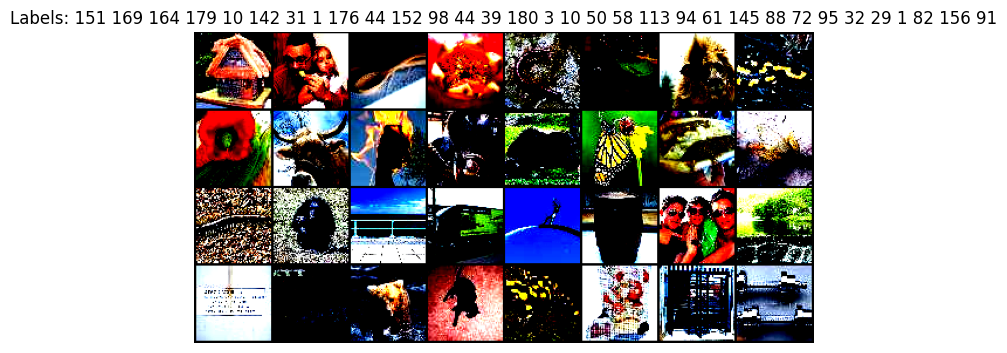

In [99]:
batch = next(iter(train_loader))
images  = batch["image"]                          # shape (B, 3, H, W)
labels  = batch["labels"] if "labels" in batch else batch["label"]

grid = make_grid(images[:32], nrow=8, padding=2)  # (3, H’, W’)

npimg = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis("off")
plt.title("Labels: " + " ".join(str(x) for x in labels[:32].tolist()))
plt.show()


      Model: MLP-based CNN
      Size: 7.751 MB
      Inference FLOPS: 2.70
      Number of parameters: 2.03 Million
      Avg Inference time: 0.65 ms
      Confusion Matrix of KAN-based CNN: Plotted Successfully
      

      Model: B-Spline-based CNN
      Size: 7.126 MB
      Inference FLOPS: 0.47
      Number of parameters: 1.87 Million
      Avg Inference time: 2.51 ms
      Confusion Matrix of KAN-based CNN: Plotted Successfully
      


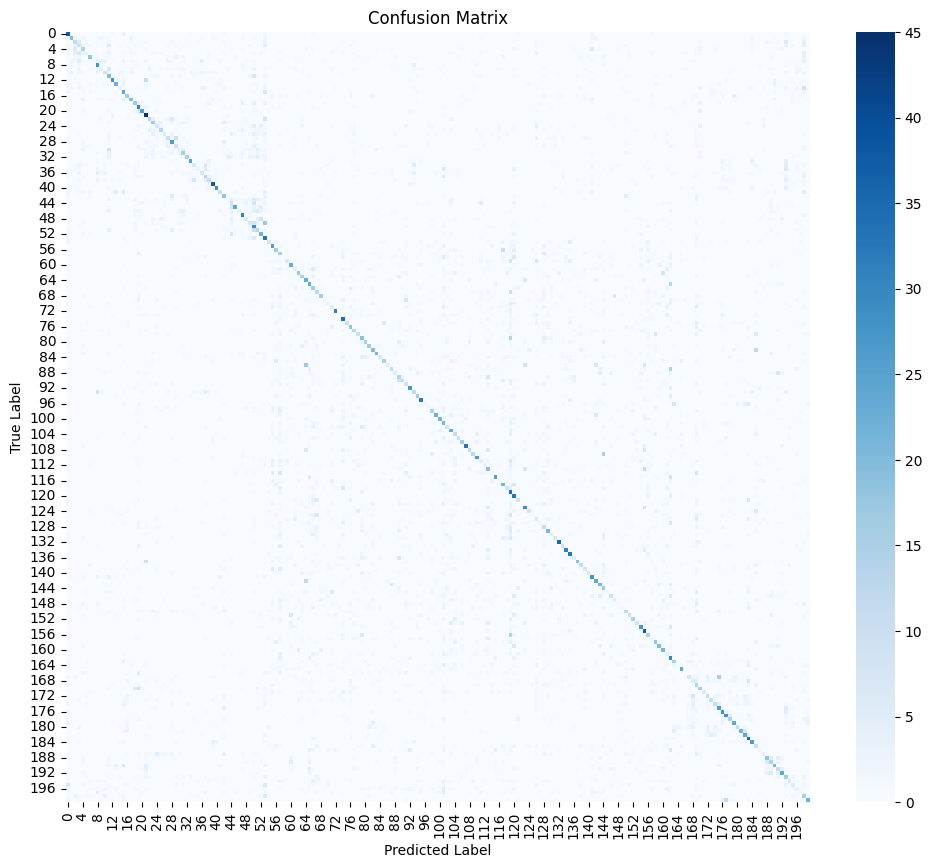

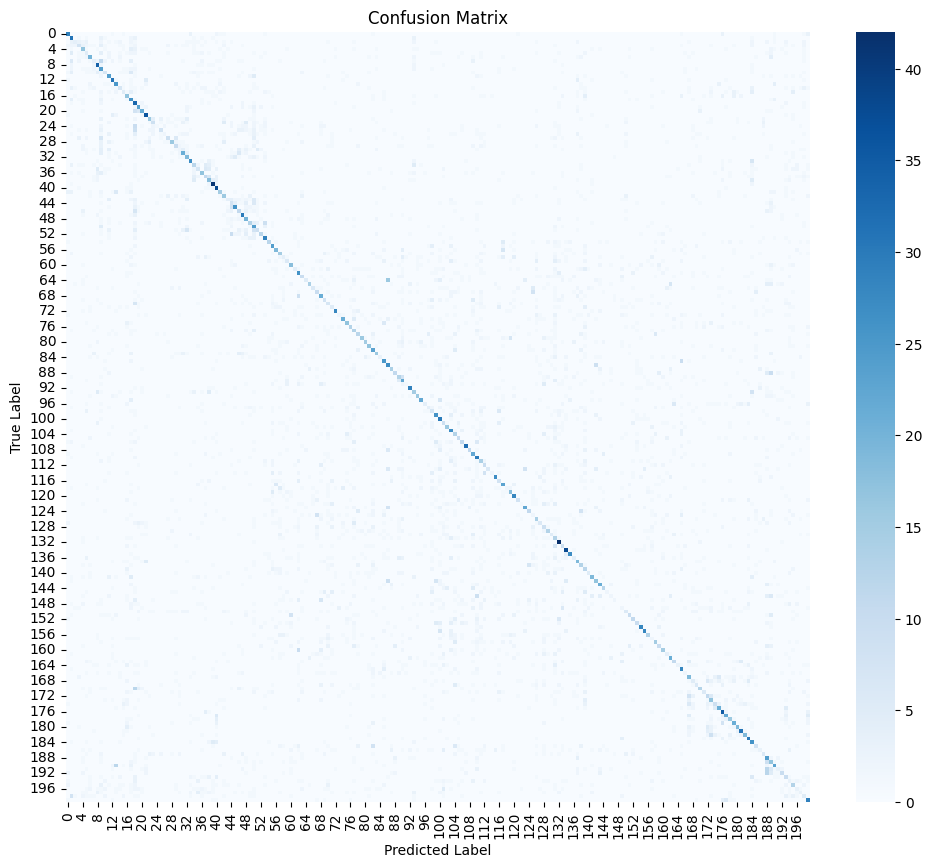

In [100]:
print(f"""
      Model: MLP-based CNN
      Size: {(b_model_size):.3f} MB
      Inference FLOPS: {b_macs_gflops:.2f}
      Number of parameters: {b_params_m:.2f} Million
      Avg Inference time: {b_avg_inference_time:.2f} ms
      Confusion Matrix of KAN-based CNN: Plotted {plot_confusion_matrix(baseline, test_loader=test_loader)}
      """)

print(f"""
      Model: B-Spline-based CNN
      Size: {(k_model_size):.3f} MB
      Inference FLOPS: {k_macs_gflops:.2f}
      Number of parameters: {k_params_m:.2f} Million
      Avg Inference time: {k_avg_inference_time:.2f} ms
      Confusion Matrix of KAN-based CNN: Plotted {plot_confusion_matrix(kan, test_loader=test_loader)}
      """)

### Optimize KAN

In [101]:
pbounds = {
    # ints → we pass floats in but will round later
    "epochs":             (20, 50),
    "kan_1":          (100, 512),   # width of first KAN layer
    "kan_2":          (100, 512),   # second KAN layer
    "kan_3":            (200, 200),
    "spline_cp":          (5, 10),      # control points
    "spline_deg":         (2, 4),      # deg ≤ cp‑1 guard enforced later
    "range_min":          (-2.0, -0.5),
    "range_max":          (40.0, 80.0),
    "lr":                 (1e-4, 1e-2)
}

import time
from tqdm.auto import tqdm

def train_kan(model, train_loader, val_loader, epochs, lr):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optim     = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)

    best_val = 0.0
    for ep in range(1, epochs + 1):
        tic = time.time()
        # ─ train ─
        model.train()
        loss_sum = acc_sum = 0.0
        for batch in train_loader:
            x, y = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad(set_to_none=True)
            logits = model(x)
            loss   = criterion(logits, y)
            loss.backward()
            optim.step()

            acc = (logits.argmax(1) == y).float().mean().item()
            loss_sum += loss.item() * x.size(0)
            acc_sum  += acc * x.size(0)

        # ─ eval ─
        model.eval()
        loss_sum_val = acc_sum_val = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch["image"].to(device), batch["label"].to(device)
                logits = model(x)
                loss   = criterion(logits, y)
                acc    = (logits.argmax(1) == y).float().mean().item()
                loss_sum_val += loss.item() * x.size(0)
                acc_sum_val  += acc * x.size(0)

        train_loss = loss_sum     / len(train_loader.dataset)
        train_acc  = acc_sum      / len(train_loader.dataset)
        val_loss   = loss_sum_val / len(val_loader.dataset)
        val_acc    = acc_sum_val  / len(val_loader.dataset)
        elapsed    = time.time() - tic

        # ← print exactly like you had it
        print(f"Epoch [{ep}/{epochs}], "
              f"Loss: {train_loss:.4f}, "
              f"Test Acc: {val_acc*100:5.2f}%, "
              f"Time: {elapsed:5.2f} seconds")

        best_val = max(best_val, val_acc)

    return best_val


def optimize_kan(epochs,
                 kan_1,
                 kan_2,
                 kan_3,
                 spline_cp,
                 spline_deg,
                 range_min,
                 range_max,
                 lr):

    # ─ cast + sanity ─
    epochs      = int(round(epochs))
    kan_1   = int(round(kan_1))
    kan_2   = int(round(kan_2))
    kan_3   = int(round(kan_3))
    spline_cp   = int(round(spline_cp))
    spline_deg  = int(round(spline_deg))

    # keep B‑spline well‑formed
    spline_deg  = max(2, min(spline_deg, spline_cp - 1))
    lr          = float(lr)

    model = KANCNN(
        kan_1=kan_1,
        kan_2=kan_2,
        kan_3=kan_3,
        spline_cp=spline_cp,
        spline_deg=spline_deg,
        range_min=range_min,
        range_max=range_max
    )

    val_acc = train_kan(model, train_loader, val_loader, epochs, lr)

    # BayesOpt maximizes the returned value
    return val_acc



In [102]:


optimize_by_input = input("Would you like to optimize for the KAN? y/n")
if optimize_by_input == "y":
    optimizer = BayesianOptimization(
        f=optimize_kan,
        pbounds=pbounds,
        random_state=38,
        verbose=2
    )

    optimizer.maximize(init_points=2, n_iter=20)

    print("Best combo so far →", optimizer.max)
else:
    print("No optimization applied.")

No optimization applied.
